In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['__MACOSX', '__notebook__.ipynb', 'plates']


In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['train', 'test', '.DS_Store']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 4273.05it/s]


In [4]:
!ls train

cleaned  dirty


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    #transforms.CenterCrop(180),
    #transforms.CenterCrop(160),
    #transforms.CenterCrop(140),
    #transforms.CenterCrop(120),
    transforms.RandomResizedCrop(224,scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(360),
    transforms.ColorJitter(0.6, 0.6, 0.3, 0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)

(4, 32)

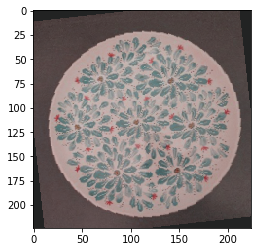

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

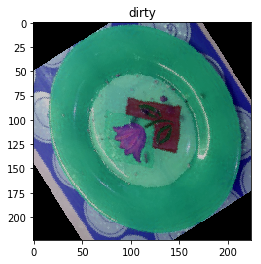

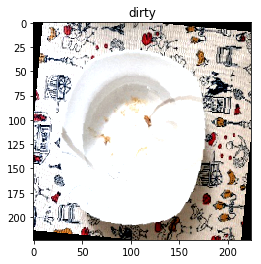

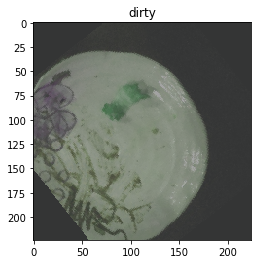

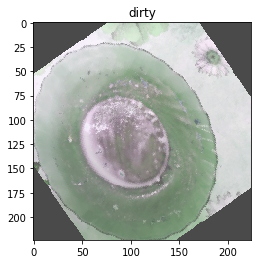

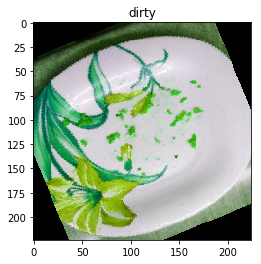

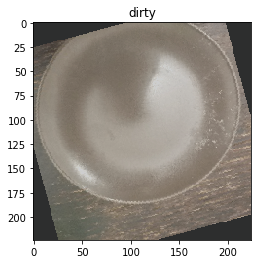

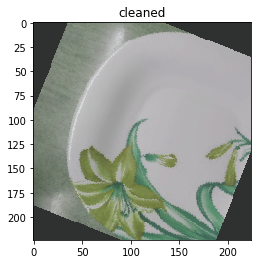

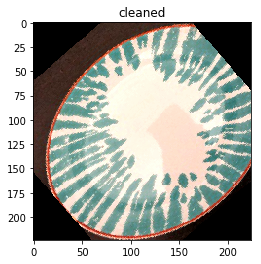

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [10]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 90115067.92it/s]


In [11]:
train_model(model, loss, optimizer, scheduler, num_epochs=93);

Epoch 0/92:


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

train Loss: 7.5436 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

val Loss: 14.0360 Acc: 0.5000
Epoch 1/92:



100%|██████████| 4/4 [00:00<00:00,  6.53it/s]

train Loss: 9.4014 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

val Loss: 5.1518 Acc: 0.6250
Epoch 2/92:



100%|██████████| 4/4 [00:00<00:00,  7.02it/s]

train Loss: 8.7916 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

val Loss: 18.5851 Acc: 0.5000
Epoch 3/92:



100%|██████████| 4/4 [00:00<00:00,  7.47it/s]

train Loss: 11.5691 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

val Loss: 29.9542 Acc: 0.5000
Epoch 4/92:



100%|██████████| 4/4 [00:00<00:00,  7.88it/s]

train Loss: 10.8211 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

val Loss: 20.0919 Acc: 0.2500
Epoch 5/92:



100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

train Loss: 21.5875 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

val Loss: 35.7277 Acc: 0.3750
Epoch 6/92:



100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

train Loss: 5.5405 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

val Loss: 27.4486 Acc: 0.2500
Epoch 7/92:



100%|██████████| 4/4 [00:00<00:00,  7.76it/s]

train Loss: 2.0357 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

val Loss: 22.4215 Acc: 0.2500
Epoch 8/92:



100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

train Loss: 0.4663 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

val Loss: 22.1241 Acc: 0.2500
Epoch 9/92:



100%|██████████| 4/4 [00:00<00:00,  7.55it/s]

train Loss: 3.2365 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

val Loss: 22.3729 Acc: 0.2500
Epoch 10/92:



100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

train Loss: 3.4759 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

val Loss: 22.3119 Acc: 0.3750
Epoch 11/92:



100%|██████████| 4/4 [00:00<00:00,  7.44it/s]

train Loss: 3.1647 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

val Loss: 23.6665 Acc: 0.3750
Epoch 12/92:



100%|██████████| 4/4 [00:00<00:00,  8.15it/s]

train Loss: 3.1429 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

val Loss: 25.7091 Acc: 0.3750
Epoch 13/92:



100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

train Loss: 2.8097 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

val Loss: 27.4357 Acc: 0.3750
Epoch 14/92:



100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

train Loss: 2.9181 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

val Loss: 29.1571 Acc: 0.3750
Epoch 15/92:



100%|██████████| 4/4 [00:00<00:00,  5.83it/s]

train Loss: 4.2475 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

val Loss: 27.2291 Acc: 0.3750
Epoch 16/92:



100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

train Loss: 6.0505 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

val Loss: 25.4064 Acc: 0.3750
Epoch 17/92:



100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

train Loss: 2.4677 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

val Loss: 25.7730 Acc: 0.3750
Epoch 18/92:



100%|██████████| 4/4 [00:00<00:00,  8.06it/s]

train Loss: 2.9738 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

val Loss: 26.9810 Acc: 0.3750
Epoch 19/92:



100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

train Loss: 4.3187 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

val Loss: 26.0915 Acc: 0.3750
Epoch 20/92:



100%|██████████| 4/4 [00:00<00:00,  8.20it/s]

train Loss: 3.2331 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

val Loss: 23.2498 Acc: 0.3750
Epoch 21/92:



100%|██████████| 4/4 [00:00<00:00,  7.63it/s]

train Loss: 3.7599 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

val Loss: 24.6269 Acc: 0.3750
Epoch 22/92:



100%|██████████| 4/4 [00:00<00:00,  7.61it/s]

train Loss: 0.3004 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

val Loss: 25.0245 Acc: 0.3750
Epoch 23/92:



100%|██████████| 4/4 [00:00<00:00,  7.88it/s]

train Loss: 2.4246 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

val Loss: 25.4825 Acc: 0.3750
Epoch 24/92:



100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

train Loss: 2.9163 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

val Loss: 25.7967 Acc: 0.3750
Epoch 25/92:



100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

train Loss: 5.6363 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

val Loss: 25.1498 Acc: 0.3750
Epoch 26/92:



100%|██████████| 4/4 [00:00<00:00,  5.90it/s]

train Loss: 5.3062 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

val Loss: 26.6099 Acc: 0.3750
Epoch 27/92:



100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

train Loss: 3.8984 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

val Loss: 25.9621 Acc: 0.3750
Epoch 28/92:



100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

train Loss: 2.5490 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 25.7648 Acc: 0.3750
Epoch 29/92:



100%|██████████| 4/4 [00:00<00:00,  6.55it/s]

train Loss: 6.2816 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

val Loss: 25.7224 Acc: 0.3750
Epoch 30/92:



100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

train Loss: 4.2933 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

val Loss: 24.8738 Acc: 0.3750
Epoch 31/92:



100%|██████████| 4/4 [00:00<00:00,  7.71it/s]

train Loss: 3.6734 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

val Loss: 25.1156 Acc: 0.3750
Epoch 32/92:



100%|██████████| 4/4 [00:00<00:00,  7.91it/s]

train Loss: 1.7641 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

val Loss: 24.5890 Acc: 0.3750
Epoch 33/92:



100%|██████████| 4/4 [00:00<00:00,  7.67it/s]

train Loss: 7.8482 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

val Loss: 23.7868 Acc: 0.3750
Epoch 34/92:



100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

train Loss: 1.7660 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

val Loss: 24.8713 Acc: 0.3750
Epoch 35/92:



100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

train Loss: 2.8189 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

val Loss: 24.3216 Acc: 0.3750
Epoch 36/92:



100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

train Loss: 1.9846 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

val Loss: 23.8260 Acc: 0.3750
Epoch 37/92:



100%|██████████| 4/4 [00:00<00:00,  7.38it/s]

train Loss: 7.6416 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

val Loss: 24.0466 Acc: 0.3750
Epoch 38/92:



100%|██████████| 4/4 [00:00<00:00,  7.91it/s]

train Loss: 5.2542 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

val Loss: 24.3237 Acc: 0.3750
Epoch 39/92:



100%|██████████| 4/4 [00:00<00:00,  7.89it/s]

train Loss: 1.5078 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

val Loss: 24.3574 Acc: 0.3750
Epoch 40/92:



100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

train Loss: 1.9480 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

val Loss: 24.4767 Acc: 0.3750
Epoch 41/92:



100%|██████████| 4/4 [00:00<00:00,  5.53it/s]

train Loss: 3.7444 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

val Loss: 24.5068 Acc: 0.3750
Epoch 42/92:



100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

train Loss: 2.7742 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

val Loss: 24.0738 Acc: 0.3750
Epoch 43/92:



100%|██████████| 4/4 [00:00<00:00,  7.52it/s]

train Loss: 3.2693 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

val Loss: 24.2548 Acc: 0.3750
Epoch 44/92:



100%|██████████| 4/4 [00:00<00:00,  3.44it/s]

train Loss: 1.5494 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

val Loss: 25.6401 Acc: 0.3750
Epoch 45/92:



100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

train Loss: 2.8425 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

val Loss: 26.3572 Acc: 0.3750
Epoch 46/92:



100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

train Loss: 2.3976 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

val Loss: 27.7270 Acc: 0.3750
Epoch 47/92:



100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

train Loss: 2.3520 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

val Loss: 26.7947 Acc: 0.3750
Epoch 48/92:



100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

train Loss: 2.3460 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

val Loss: 25.0393 Acc: 0.3750
Epoch 49/92:



100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

train Loss: 2.9014 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

val Loss: 25.0071 Acc: 0.3750
Epoch 50/92:



100%|██████████| 4/4 [00:00<00:00,  5.10it/s]

train Loss: 9.9455 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

val Loss: 24.9894 Acc: 0.3750
Epoch 51/92:



100%|██████████| 4/4 [00:00<00:00,  2.16it/s]

train Loss: 0.5211 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

val Loss: 24.8014 Acc: 0.3750
Epoch 52/92:



100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

train Loss: 7.1963 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

val Loss: 24.7532 Acc: 0.3750
Epoch 53/92:



100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

train Loss: 4.6494 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

val Loss: 24.4955 Acc: 0.3750
Epoch 54/92:



100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

train Loss: 4.5829 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

val Loss: 24.0519 Acc: 0.3750
Epoch 55/92:



100%|██████████| 4/4 [00:00<00:00,  5.01it/s]

train Loss: 2.4426 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

val Loss: 24.6066 Acc: 0.3750
Epoch 56/92:



100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

train Loss: 2.1198 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 24.9997 Acc: 0.3750
Epoch 57/92:



100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

train Loss: 3.0729 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

val Loss: 24.6152 Acc: 0.3750
Epoch 58/92:



100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

train Loss: 4.3409 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

val Loss: 24.5002 Acc: 0.3750
Epoch 59/92:



100%|██████████| 4/4 [00:00<00:00,  5.08it/s]

train Loss: 0.9634 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

val Loss: 24.2080 Acc: 0.3750
Epoch 60/92:



100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

train Loss: 4.5263 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 24.1136 Acc: 0.3750
Epoch 61/92:



100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

train Loss: 1.2582 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

val Loss: 24.1706 Acc: 0.3750
Epoch 62/92:



100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

train Loss: 4.9571 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

val Loss: 24.2095 Acc: 0.3750
Epoch 63/92:



100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

train Loss: 7.5946 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

val Loss: 25.4986 Acc: 0.3750
Epoch 64/92:



100%|██████████| 4/4 [00:00<00:00,  5.03it/s]

train Loss: 2.2465 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 24.8751 Acc: 0.3750
Epoch 65/92:



100%|██████████| 4/4 [00:00<00:00,  5.08it/s]

train Loss: 3.7313 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

val Loss: 24.9334 Acc: 0.3750
Epoch 66/92:



100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

train Loss: 3.0783 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

val Loss: 24.9976 Acc: 0.3750
Epoch 67/92:



100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

train Loss: 2.1317 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

val Loss: 24.0760 Acc: 0.3750
Epoch 68/92:



100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

train Loss: 2.0907 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

val Loss: 25.3133 Acc: 0.3750
Epoch 69/92:



100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

train Loss: 2.0618 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

val Loss: 24.5321 Acc: 0.3750
Epoch 70/92:



100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

train Loss: 6.9358 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

val Loss: 23.9434 Acc: 0.3750
Epoch 71/92:



100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

train Loss: 2.9613 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

val Loss: 25.0325 Acc: 0.3750
Epoch 72/92:



100%|██████████| 4/4 [00:00<00:00,  4.90it/s]

train Loss: 4.9052 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

val Loss: 25.1984 Acc: 0.3750
Epoch 73/92:



100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

train Loss: 1.4961 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

val Loss: 24.6932 Acc: 0.3750
Epoch 74/92:



100%|██████████| 4/4 [00:00<00:00,  7.65it/s]

train Loss: 3.2567 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

val Loss: 25.9612 Acc: 0.3750
Epoch 75/92:



100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

train Loss: 2.6115 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

val Loss: 26.2484 Acc: 0.3750
Epoch 76/92:



100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

train Loss: 1.0336 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

val Loss: 26.3391 Acc: 0.3750
Epoch 77/92:



100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

train Loss: 4.7334 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

val Loss: 25.8058 Acc: 0.3750
Epoch 78/92:



100%|██████████| 4/4 [00:00<00:00,  7.59it/s]

train Loss: 1.7088 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

val Loss: 24.2144 Acc: 0.3750
Epoch 79/92:



100%|██████████| 4/4 [00:00<00:00,  7.68it/s]

train Loss: 4.2607 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

val Loss: 24.8535 Acc: 0.3750
Epoch 80/92:



100%|██████████| 4/4 [00:00<00:00,  7.65it/s]

train Loss: 2.4081 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

val Loss: 23.2129 Acc: 0.3750
Epoch 81/92:



100%|██████████| 4/4 [00:00<00:00,  5.68it/s]

train Loss: 3.0879 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

val Loss: 24.6292 Acc: 0.3750
Epoch 82/92:



100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

train Loss: 3.5603 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

val Loss: 24.7386 Acc: 0.3750
Epoch 83/92:



100%|██████████| 4/4 [00:00<00:00,  7.66it/s]

train Loss: 2.3447 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

val Loss: 25.8627 Acc: 0.3750
Epoch 84/92:



100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

train Loss: 4.1882 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

val Loss: 26.1078 Acc: 0.3750
Epoch 85/92:



100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

train Loss: 3.0826 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

val Loss: 26.4384 Acc: 0.3750
Epoch 86/92:



100%|██████████| 4/4 [00:00<00:00,  7.29it/s]

train Loss: 3.1254 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

val Loss: 26.1264 Acc: 0.3750
Epoch 87/92:



100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

train Loss: 4.6047 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

val Loss: 27.2097 Acc: 0.3750
Epoch 88/92:



100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

train Loss: 4.1030 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

val Loss: 26.5529 Acc: 0.3750
Epoch 89/92:



100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

train Loss: 5.4644 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

val Loss: 26.9222 Acc: 0.3750
Epoch 90/92:



100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

train Loss: 6.8757 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

val Loss: 25.0546 Acc: 0.3750
Epoch 91/92:



100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

train Loss: 0.4291 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

val Loss: 26.3014 Acc: 0.3750
Epoch 92/92:



100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

train Loss: 2.0796 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

val Loss: 25.9186 Acc: 0.3750


In [12]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [13]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [15]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 26.59it/s]


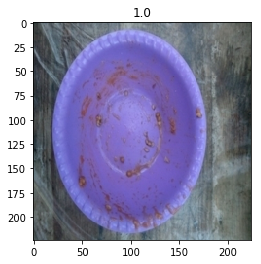

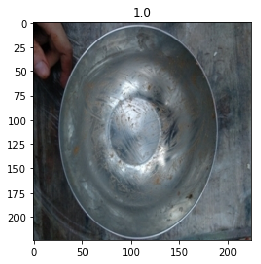

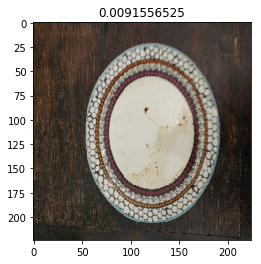

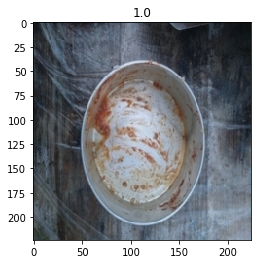

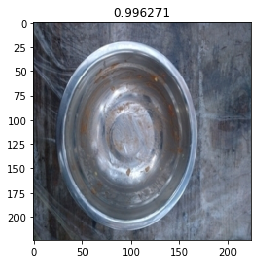

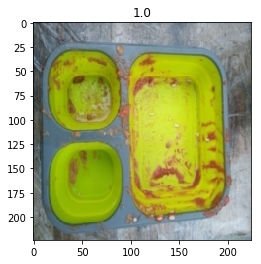

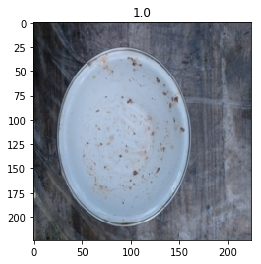

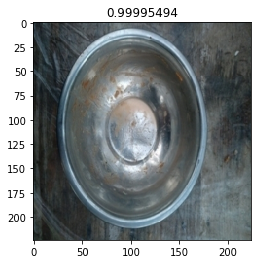

In [16]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [17]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [18]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.8 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [19]:
submission_df.to_csv('submission.csv')

In [20]:
!rm -rf train val test